# Optimization algorithm

Until the previous section, we applied structural optimization to various examples. <br/>
In this section, we will learn about the local optimization algorithms used in structural optimization.

## Algorithm type

As local optimization algorithms, ASE offers the `FIRE` method, which performs optimization with Molecular Dynamics (MD)-like behavior, and the `BFGS`, `LBFGS`, `BFGSLineSearch`=`QuasiNewton`, and `LBFGSLineSearch` methods are provided as [quasi-newton methods](https://en.wikipedia.org/wiki/Quasi-Newton_method).

 - https://wiki.fysik.dtu.dk/ase/ase/optimize.html
 
|  Algorithm  | Group | Description |
| ---- | ---- | ---- |
| MDMin | MD-like  | Performs MD, but resets momentum to 0 if the inner product of momentum and force is negative |
| FIRE　 |  MD-like  | MD, with various additional innovations to make it fast and robust. |
| BFGS  | Quasi-Newton | Approximate the Hessian from the optimization trajectory and run the Newton method using the approximated Hessian |
| LBFGS  | Quasi-Newton | BFGS method to run at high speed and low memory |
| BFGSLineSearch  | Quasi-Newton | BFGS determines the direction of optimization direction, and LineSearch determines the step size. |
| LBFGSLineSearch  | Quasi-Newton | LBFGS determines the direction of optimization direction, and LineSearch determines the step size. |


We exclude MDMin from the benchmark because of its large hyperparameter dependence and frequent structural optimization failures. Let's look at other optimizers.

### FIRE

FIRE basically performs MD, but some ingenious techniques are included for fast convergence.

### Newton method

The Newton method uses the Hessian and gradient to determine the next step. 
The Newton method is a quadratic convergence method, which means that when the potential is close to a quadratic function (close to the minima), it approaches the exact solution at the speed of the square and is very fast.
With the Hessian as $H$ and the gradient as $\vec{g}$, the next optimization step $\vec{p}$ is expressed as follows

$\vec{p} = - H^{-1} \vec{g}$

If the potential were strictly quadratic, it would converge to a minimum in one step.

### Quasi-Newton Method

Since the evaluation of the Hessian is onerous (for example, it can be obtained numerically by computing force 6N times), it is often more meaningful to use the time spent computing the Hessian to proceed with structural optimization. Therefore, using the optimization trajectory, a quasi-Newton method approximates the Hessian in a short time. Since the Hessian is not exact, it does not converge in as few steps as the Newton method but still converges fast.

### BFGS

The BFGS method is the most standard Hessian approximation method among the quasi-Newtonian methods. Various other methods are known, such as the SR1 and DFP methods, but the BFGS method is implemented in ASE.

### LBFGS

One drawback of the BFGS method is that it requires storing a matrix of the size of the variable's dimension to optimize and calculate the matrix-vector product.
This means $O(N^2)$ for dimension $N$ in space and $O(N^2)$ in time are required, which is not suitable for optimizing multidimensional functions.
Therefore, the LBFGS method is a method that can reproduce BFGS with a computational complexity of $O(N)$ by using only the information from the last few trajectories and transforming it so that the results are almost the same as the BFGS method.
Since the computational complexity of PFP is $O(N)$, the computational time in Optimizer becomes noticeable from about 300 atoms using the $O(N^2)$ method like BFGS. However, in LBFGS, the computational time in optimizer is not noticeable even if the number of atoms increases.

### LineSearch

If the potential is not quadratic, the Newton method may oscillate. 
Also, the quasi-Newton method may not provide an appropriate step size because the Hessian may not be accurate.
In these cases, LineSearch can be used to stabilize the optimization in order to converge the optimization.
After determining the direction of optimization using the quasi-Newton method, it is desirable to decide a step size such that the energy is sufficiently small in that direction. 
LineSearch determines such a step size by actually calculating several points.
With BFGS, there may be cases where the energy increases as a result of calculation according to the Newton method, but BFGSLineSearch searches for a good step size.

## Benchmark

In [1]:
import os
from time import perf_counter
from typing import Optional, Type

import matplotlib.pyplot as plt
import pandas as pd
from ase import Atoms
from ase.build import bulk, molecule
from ase.calculators.calculator import Calculator
from ase.io import Trajectory
from ase.optimize import BFGS, FIRE, LBFGS, BFGSLineSearch, LBFGSLineSearch, MDMin
from ase.optimize.optimize import Optimizer
from tqdm.auto import tqdm

import pfp_api_client
from pfcc_extras.structure.ase_rdkit_converter import atoms_to_smiles, smiles_to_atoms
from pfcc_extras.visualize.view import view_ngl
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode

In [2]:
calc = ASECalculator(Estimator(calc_mode=EstimatorCalcMode.CRYSTAL, model_version="v2.0.0"))
calc_mol = ASECalculator(Estimator(calc_mode=EstimatorCalcMode.MOLECULE, model_version="v2.0.0"))
print(f"pfp_api_client: {pfp_api_client.__version__}")
print(calc.estimator.model_version)

pfp_api_client: 1.5.0
v2.0.0


### Comparison of number of steps (force calculation)

Below is a simple example of a structural optimization of a CH3CHO molecule. <br/>
The structure obtained by `molecule("CH3CHO")` is not strictly stable, but it is a fairly good initial structure.
Therefore, when starting from such a structure, the quasi-Newton method can be used to complete the structural optimization in a much smaller number of PFP calls.

First, let's benchmark how many times force is calculated until the structural optimization is complete.
Here, we take the structure of the bulk of Pt moved randomly as the initial structure and measure the number of force calculations until the optimal structure is achieved.

In [3]:
def get_force_calls(opt: Optimizer) -> int:
    """Obtrain number of force calculations"""
    if isinstance(opt, (BFGSLineSearch, LBFGSLineSearch)):
        return opt.force_calls
    else:
        return opt.nsteps

In [4]:
os.makedirs("output", exist_ok=True)

In [5]:
atoms_0 = bulk("Pt") * (4, 4, 4)
atoms_0.rattle(stdev=0.1)

In [6]:
view_ngl(atoms_0)

In [7]:
force_calls = {}
for opt_class in tqdm([FIRE, BFGS, LBFGS, BFGSLineSearch, LBFGSLineSearch]):
    atoms = atoms_0.copy()
    atoms.calc = calc
    name = opt_class.__name__
    with opt_class(atoms, trajectory=f"output/{name}_ch3cho.traj", logfile=None) as opt:
        opt.run(fmax=0.05)
        force_calls[name] = [get_force_calls(opt)]

  0%|          | 0/5 [00:00<?, ?it/s]

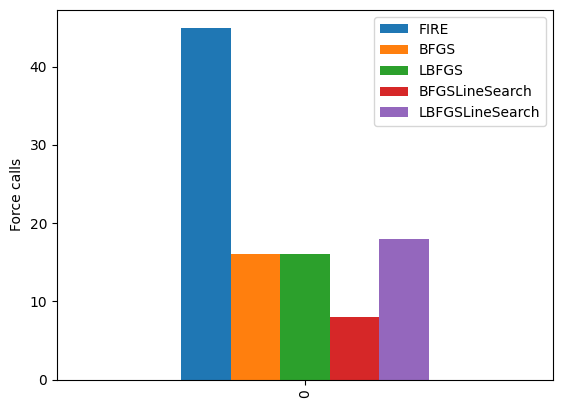

In [8]:
df = pd.DataFrame.from_dict(force_calls)
df.plot.bar()
plt.ylabel("Force calls")
plt.show()

FIRE had the highest number of force evaluation, while BFGS and LBFGS had about the same number.
The method with LineSearch also had the same number of force evaluations as BFGS and LBFGS.

### Comparison of speed per step

Next, let us compare the speed per step of each of the optimization methods.

In [9]:
from ase.build import bulk

atoms = bulk("Fe") * (10, 5, 3)
atoms.rattle(stdev=0.2)
atoms.calc = calc

view_ngl(atoms)

In [10]:
def opt_benchmark(atoms: Atoms, calculator: Calculator, opt_class, logfile: Optional[str] = "-", steps: int = 10) -> float:
    _atoms = atoms.copy()
    _atoms.calc = calculator
    with opt_class(_atoms, logfile=logfile) as opt:
        start_time = perf_counter()
        opt.run(steps=steps)
        end_time = perf_counter()
        duration = end_time - start_time
        duration_per_force_calls = duration / get_force_calls(opt)
    return duration_per_force_calls

In [11]:
result_dict = {
    "n_atoms": [],
    "FIRE": [],
    "BFGS": [],
    "LBFGS": [],
    "BFGSLineSearch": [],
    "LBFGSLineSearch": [],
}


for i in range(1, 10):
    atoms = bulk("Fe") * (10, 10, i)
    atoms.rattle(stdev=0.2)
    n_atoms = atoms.get_global_number_of_atoms()
    result_dict["n_atoms"].append(n_atoms)
    print(f"----- n_atoms {n_atoms} -----")
    for opt_class in [FIRE, BFGS, LBFGS, BFGSLineSearch, LBFGSLineSearch]:
        name = opt_class.__name__
        print(f"Running {name}...")
        duration = opt_benchmark(atoms, calc, opt_class=opt_class, logfile=None, steps=10)
        print(f"Done in {duration:.2f} sec.")
        result_dict[name].append(duration)

----- n_atoms 100 -----
Running FIRE...
Done in 0.06 sec.
Running BFGS...
Done in 0.08 sec.
Running LBFGS...
Done in 0.06 sec.
Running BFGSLineSearch...
Done in 0.06 sec.
Running LBFGSLineSearch...
Done in 0.06 sec.
----- n_atoms 200 -----
Running FIRE...
Done in 0.08 sec.
Running BFGS...
Done in 0.16 sec.
Running LBFGS...
Done in 0.08 sec.
Running BFGSLineSearch...
Done in 0.11 sec.
Running LBFGSLineSearch...
Done in 0.08 sec.
----- n_atoms 300 -----
Running FIRE...
Done in 0.12 sec.
Running BFGS...
Done in 0.32 sec.
Running LBFGS...
Done in 0.11 sec.
Running BFGSLineSearch...
Done in 0.19 sec.
Running LBFGSLineSearch...
Done in 0.11 sec.
----- n_atoms 400 -----
Running FIRE...
Done in 0.15 sec.
Running BFGS...
Done in 0.59 sec.
Running LBFGS...
Done in 0.15 sec.
Running BFGSLineSearch...
Done in 0.31 sec.
Running LBFGSLineSearch...
Done in 0.15 sec.
----- n_atoms 500 -----
Running FIRE...
Done in 0.18 sec.
Running BFGS...
Done in 0.94 sec.
Running LBFGS...
Done in 0.18 sec.
Running B

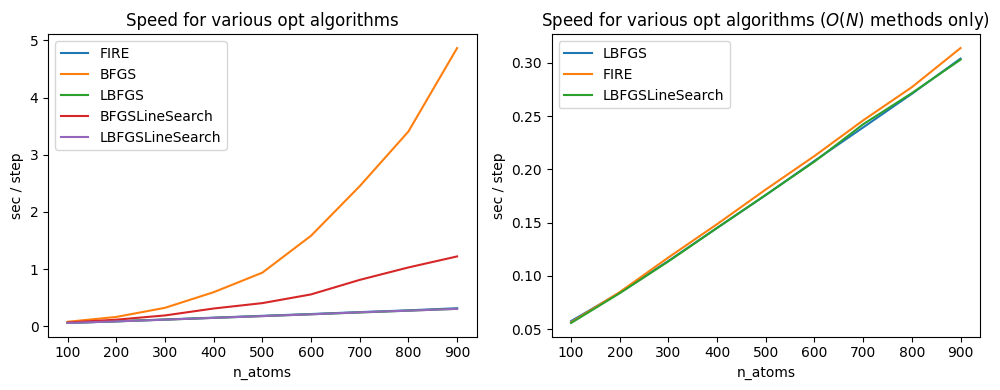

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

fig, axes = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))
df = pd.DataFrame(result_dict)
df = df.set_index("n_atoms")
df.plot(ax=axes[0])
axes[0].set_title("Speed for various opt algorithms")
df[["LBFGS", "FIRE", "LBFGSLineSearch"]].plot(ax=axes[1])
axes[1].set_title("Speed for various opt algorithms ($O(N)$ methods only)")
for ax in axes:
    ax.set_ylabel("sec / step")
fig.savefig("output/opt_benchmark.png")
plt.show(fig)

In BFGS and BFGSLineSearch, the calculation time per step increases as the number of atoms increases.

The BFGS method implemented in ASE performs eigenvalue decomposition at each step to find the Hessian inverse matrix.
Since the Hessian has a size of 3N, where N is the number of atoms, and the eigenvalue decomposition takes $O(N^3)$ computational time, the BFGS method in ASE slows down rapidly on the order of the cube of the number of atoms.

BFGSLineSearch directly approximates the Hessian inverse matrix without performing Hessian eigenvalue decomposition. 
This makes it faster than BFGS, $O(N^2)$ computational time because the matrix-vector product becomes the rate-limiting factor.

However, it is much slower than LBFGS and FIRE, which operate on $O(N)$ when the number of atoms is large.

## Use of different optimization algorithms

We have seen that FIRE requires more force calls than other methods, and that BFGS and BFGSLineSearch are more rate-limiting in the internal routines of the optimizer than in force evaluation when the number of atoms is large.
So in what cases should we use LBFGS and LBFGSLineSearch?
We will now look at some cases where even those algorithms do not work.

### Examples of LBFGS and BFGS fail

Let's look at the next example.
This example uses a very simple potential, the Lennard-Jones (LJ) potential, and performs structural optimization with initial values away from its stability point.

 - https://wiki.fysik.dtu.dk/ase/ase/calculators/others.html#lennard-jones

LJ potential is expressed as follows, and can be visualized as below

$$ \phi (r) = 4 \epsilon \bigg\{ \left( \frac{\sigma}{r} \right) ^{12} -  \left( \frac{\sigma}{r} \right) ^{6} \bigg\} $$


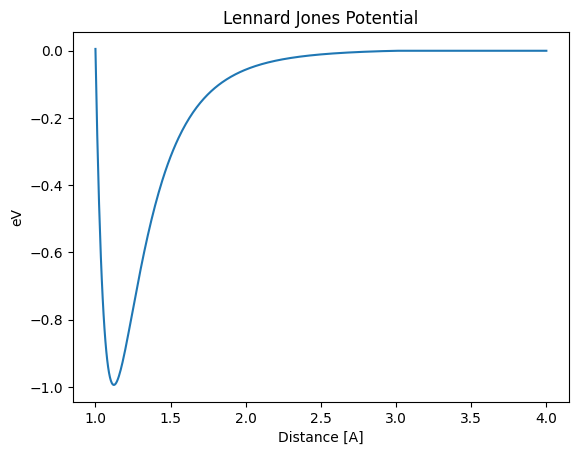

In [15]:
from ase.calculators.lj import LennardJones
import numpy as np


calc_lj = LennardJones()

dists = np.linspace(1.0, 4.0, 500)


E_pot_list = []
for d in dists:
    atoms = Atoms("Ar2", [[0, 0, 0], [d, 0, 0]])
    atoms.calc = calc_lj
    E_pot = atoms.get_potential_energy()
    E_pot_list.append(E_pot)

plt.plot(dists, E_pot_list)
plt.title("Lennard Jones Potential")
plt.ylabel("eV")
plt.xlabel("Distance [A]")
plt.show()

Let's run a structural optimization of this simple potential form by starting the distance away from the stability point, 1.12A.

In [16]:
def lennard_jones_trajectory(opt_class: Type[Optimizer], d0: float):
    name = opt_class.__name__
    trajectory_path = f"output/Ar_{name}.traj"

    atoms = Atoms("Ar2", [[0, 0, 0], [d0, 0, 0]])
    atoms.calc = calc_lj

    opt = opt_class(atoms, trajectory=trajectory_path)
    opt.run()

    distance_list = []
    energy_list = []
    for atoms in Trajectory(trajectory_path):
        energy_list.append(atoms.get_potential_energy())
        distance_list.append(atoms.get_distance(0, 1))

    print("Distance in opt trajectory: ", distance_list)

    plt.plot(dists, E_pot_list)
    plt.plot(distance_list, energy_list, marker="x")
    plt.title(f"Lennard Jones Potential: {name} opt")
    plt.ylim(-1.0, 0)
    plt.ylabel("eV")
    plt.xlabel("Distance [A]")
    plt.show()

The first case is when FIRE is used. The optimum value of 1.12A is reached in a stable manner.

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 06:34:10       -0.314857*       1.1580
FIRE:    1 06:34:10       -0.342894*       1.2644
FIRE:    2 06:34:10       -0.410024*       1.5124
FIRE:    3 06:34:10       -0.546744*       1.9683
FIRE:    4 06:34:10       -0.812180*       2.3839
FIRE:    5 06:34:10       -0.862167*       5.5858
FIRE:    6 06:34:10       -0.966377*       2.1492
FIRE:    7 06:34:10       -0.991817*       0.5223
FIRE:    8 06:34:10       -0.992148*       0.4913
FIRE:    9 06:34:10       -0.992732*       0.4299
FIRE:   10 06:34:10       -0.993427*       0.3400
FIRE:   11 06:34:10       -0.994057*       0.2245
FIRE:   12 06:34:10       -0.994451*       0.0884
FIRE:   13 06:34:10       -0.994489*       0.0606
FIRE:   14 06:34:10       -0.994490*       0.0595
FIRE:   15 06:34:10       -0.994492*       0.0573
FIRE:   16 06:34:10       -0.994495*       0.0541
FIRE:   17 06:34:10       -0.994499*       0.0499
Di

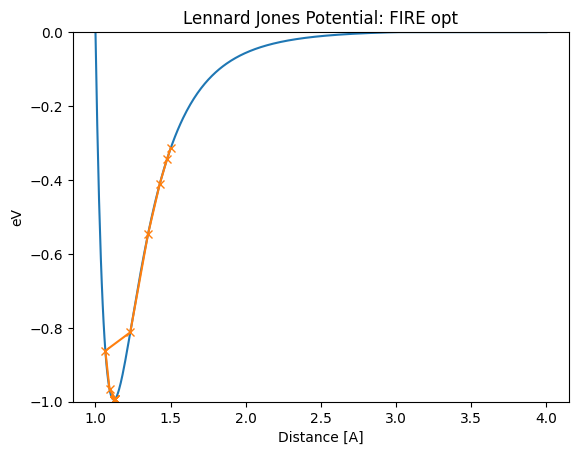

In [17]:
lennard_jones_trajectory(FIRE, 1.5)

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 06:34:10       -0.697220*       2.3246
FIRE:    1 06:34:10       -0.807702*       2.3874
FIRE:    2 06:34:10       -0.987241*       0.8220
FIRE:    3 06:34:10       -0.520102*      13.5704
FIRE:    4 06:34:10       -0.971689*       1.9036
FIRE:    5 06:34:10       -0.939109*       1.8400
FIRE:    6 06:34:10       -0.943288*       1.7937
FIRE:    7 06:34:10       -0.951214*       1.6946
FIRE:    8 06:34:10       -0.961964*       1.5294
FIRE:    9 06:34:10       -0.974030*       1.2780
FIRE:   10 06:34:10       -0.985244*       0.9149
FIRE:   11 06:34:10       -0.992867*       0.4142
FIRE:   12 06:34:10       -0.994043*       0.2396
FIRE:   13 06:34:10       -0.994061*       0.2350
FIRE:   14 06:34:10       -0.994095*       0.2259
FIRE:   15 06:34:10       -0.994143*       0.2125
FIRE:   16 06:34:10       -0.994201*       0.1951
FIRE:   17 06:34:10       -0.994265*       0.1741
FI

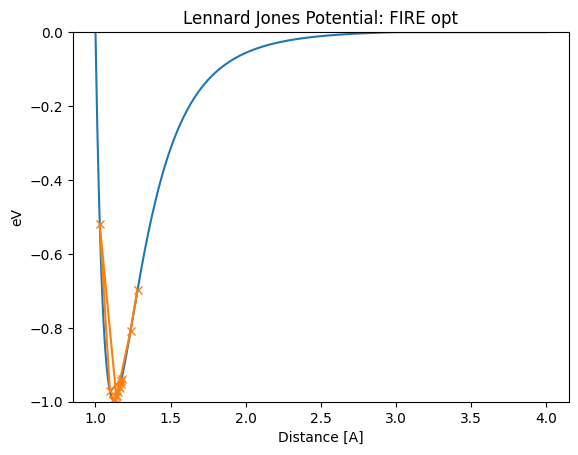

In [18]:
lennard_jones_trajectory(FIRE, 1.28)

If we start the BFGS method at 1.5A, we will find that it jumps too far at certain steps, resulting in unstable behavior that jumps far past the stability point.
(where it seems to jump from 1.18A to 0.78A.)
Thus, the distance will oscillate significantly before reaching the optimum value of 1.12A, even in this simple example.
When the function surface is very different from the second-order function and the second-order approximation method is used, its estimation of minima is far from the actual minima.

      Step     Time          Energy         fmax
BFGS:    0 06:34:11       -0.314857        1.1580
BFGS:    1 06:34:11       -0.355681        1.3124
BFGS:    2 06:34:11       -0.916039        2.0410
BFGS:    3 06:34:11       55.304434      974.4875
BFGS:    4 06:34:11       -0.917740        2.0288
BFGS:    5 06:34:11       -0.919418        2.0163
BFGS:    6 06:34:11       -0.747080        8.5176
BFGS:    7 06:34:11       -0.965068        1.4729
BFGS:    8 06:34:11       -0.984660        0.9397
BFGS:    9 06:34:11       -0.992324        0.5286
BFGS:   10 06:34:11       -0.994444        0.0924
BFGS:   11 06:34:11       -0.994520        0.0073
Distance in opt trajectory:  [1.5, 1.4669134619701096, 1.1856710148074785, 0.7856710148074794, 1.1848349876531552, 1.1840057048694352, 1.0494144415980853, 1.1582431525834571, 1.1421985974452118, 1.1139254943723882, 1.1241042745909056, 1.122589482834374]


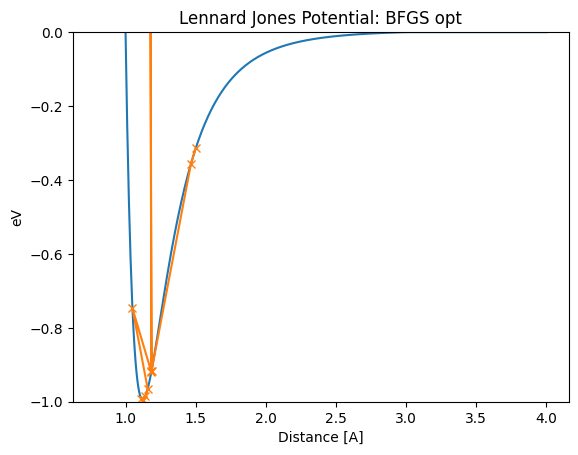

In [19]:
lennard_jones_trajectory(BFGS, 1.5)

The same thing happens with the LBFGS method.
If such oscillations occur in a polyatomic system, the optimization may not be completed for a long time.

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 06:34:11       -0.697220*       2.3246
LBFGS:    1 06:34:11       -0.854683*       2.3149
LBFGS:    2 06:34:11       33.771592*     599.7519
LBFGS:    3 06:34:11       -0.858237*       2.3057
LBFGS:    4 06:34:11       -0.861748*       2.2959
LBFGS:    5 06:34:11       17.305333*     318.4918
LBFGS:    6 06:34:11       -0.867638*       2.2781
LBFGS:    7 06:34:11       -0.873395*       2.2589
LBFGS:    8 06:34:11        5.604073*     121.1548
LBFGS:    9 06:34:11       -0.885566*       2.2113
LBFGS:   10 06:34:11       -0.897001*       2.1571
LBFGS:   11 06:34:11        0.369118*      30.7872
LBFGS:   12 06:34:11       -0.925197*       1.9707
LBFGS:   13 06:34:11       -0.947015*       1.7491
LBFGS:   14 06:34:11       -0.915603*       4.0090
LBFGS:   15 06:34:11       -0.985429*       0.9069
LBFGS:   16 06:34:11       -0.993163*       0.3771
LBFGS:   17 06:34:11       -0.9944

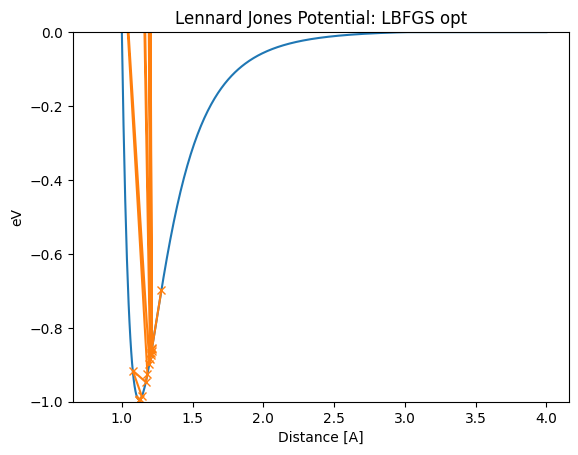

In [20]:
lennard_jones_trajectory(LBFGS, 1.28)

There are also other cases where the initial value does not reach the stability point correctly if it starts far from the stability point. <br/>
This may be caused by a problem with the initialization of Hessian or other reasons.

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 06:34:12       -0.314857*       1.1580
LBFGS:    1 06:34:12       -0.355681*       1.3124
LBFGS:    2 06:34:12       -0.129756*       0.4473
LBFGS:    3 06:34:12       -0.079409*       0.2630
LBFGS:    4 06:34:12       -0.040472*       0.1297
LBFGS:    5 06:34:12       -0.021155*       0.0689
LBFGS:    6 06:34:12       -0.009646*       0.0357
Distance in opt trajectory:  [1.5, 1.4669134619701096, 1.748155909132741, 1.8935676545167726, 2.101103976550205, 2.302941039822042, 2.531922335240822]


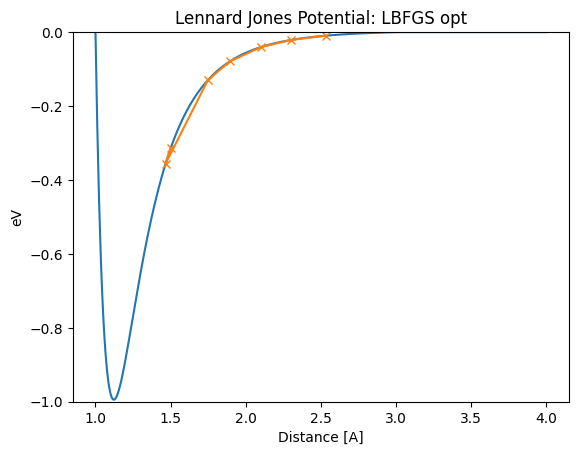

In [21]:
lennard_jones_trajectory(LBFGS, 1.50)

Thus, even in cases where BFGS and LBFGS do not work, LineSearch can be used to converge correctly.
LBFGSLineSearch is a better optimizer in most cases.

                 Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGSLineSearch:    0 06:34:12       -0.314857*       1.1580
LBFGSLineSearch:    1 06:34:13       -0.994517*       0.0214
Distance in opt trajectory:  [1.5, 1.1220880716401869]


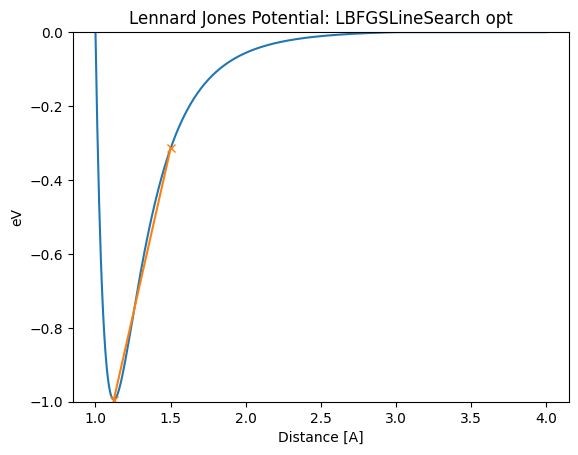

In [22]:
lennard_jones_trajectory(LBFGSLineSearch, 1.5)

LBFGSLineSearch appears to finish in a few steps, but the actual number of calculations is a bit higher because the part of LineSearch being done internally is not counted as a step. </br>
BFGSLineSearch shows Step[FC], where FC is the actual number of force evaluations.

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 06:34:13       -0.314857*       1.1580
BFGSLineSearch:    1[  5] 06:34:13       -0.994057*       0.2244
BFGSLineSearch:    2[  7] 06:34:13       -0.994520*       0.0054
Distance in opt trajectory:  [1.5, 1.1265420003736115, 1.1225561293552997]


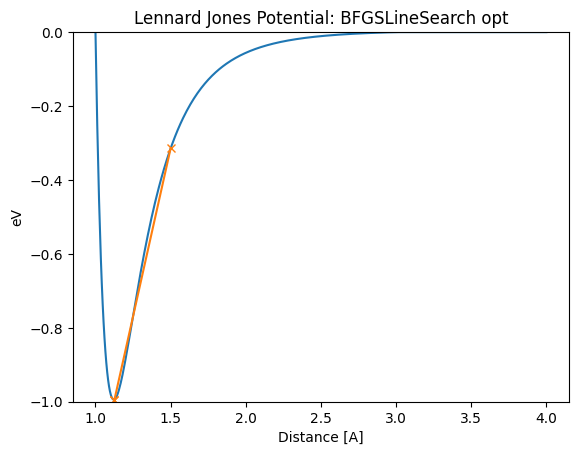

In [23]:
lennard_jones_trajectory(BFGSLineSearch, 1.5)

We have seen here that there are examples where BFGS and LBFGS do not work.
But even in these instances, LBFGSLineSearch has worked well.

Our conclusion so far is that LBFGSLineSearch is the best optimizer in many cases.
Below we discuss the shortcomings of the other optimizers.

- FIRE: Long number of steps to convergence
- BFGS: Takes a long time when the number of atoms is large.
- BFGSLineSearch: Takes a long time when the number of atoms is large.
- LBFGS: May oscillate or increase energy sometimes.

However, it is not always the case that using LBFGSLineSearch always works, unfortunately.

### Example of LBFGSLineSearch fails

`LBFGSLineSearch` is a complete method, and it will work well in many cases.
However, there are rare cases where `LBFGSLineSearch` does not work well.
For example, this is often the case when one wants to perform precise structural optimization with a small `fmax`.
If you want to optimize the rotation of the methyl group of toluene, you need to set `fmax=0.001` eV/A to reach the minimum value for the rotation.
In this example, LineSearch will not converge easily, and one step will take a long time, or the energy will not drop, or in some cases, LineSearch will fail, and an error will occur with `RuntimeError: LineSearch failed!`

In [24]:
atoms_0 = smiles_to_atoms("Cc1ccccc1")
tmp = atoms_0[7:10]
tmp.rotate([1.0, 0.0, 0.0], 15.0)
atoms_0.positions[7:10] = tmp.positions
atoms_0.calc = calc_mol

In [25]:
view_ngl(atoms_0, representations=["ball+stick"], h=600, w=600)

In [26]:
# Please set '-', if you want to see detailed logs.
logfile = None

steps = {}
images = []
for optimizer_class in (FIRE, LBFGS, LBFGSLineSearch):
    name = optimizer_class.__name__
    atoms = atoms_0.copy()
    atoms.calc = calc_mol
    with optimizer_class(atoms, logfile=logfile) as opt:
        try:
            print(f"{name} optimization starts.")
            opt.run(fmax=0.001, steps=200)
            print(f"Optimization finished without error. steps = {opt.nsteps}")
        finally:
            steps[name] = [get_force_calls(opt)]
            images.append(atoms.copy())

FIRE optimization starts.
Optimization finished without error. steps = 200
LBFGS optimization starts.
Optimization finished without error. steps = 80
LBFGSLineSearch optimization starts.


RuntimeError: LineSearch failed!

In [27]:
steps["index"] = "nsteps"
df = pd.DataFrame(steps)
df = df.set_index("index")
df

,FIRE,LBFGS,LBFGSLineSearch
index,,,
nsteps,200,80,627


In this example, LBFGS converged, but FIRE did not.

Also, LBFGSLineSearch took a very long time per step in the latter half and did not converge, in some cases giving the error `RuntimeError: LineSearch failed!`.
In most cases, LBFGSLineSearch has difficulty converging around `fmax=0.002` eV/A. 
In some cases, even `fmax=0.05` may not be reached if the shape of the potential is worse.

If LBFGSLineSearch stops working like this, you may have to re-run LBFGSLineSearch to get it to work. (Sometimes it doesn't work.)

In [28]:
with LBFGSLineSearch(atoms) as opt:
    opt.run(0.001)

                 Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGSLineSearch:    0 06:37:34      -72.184941*       0.0481
LBFGSLineSearch:    1 06:37:34      -72.184962*       0.0229
LBFGSLineSearch:    2 06:37:34      -72.184966*       0.0086
LBFGSLineSearch:    3 06:37:34      -72.184971*       0.0084
LBFGSLineSearch:    4 06:37:34      -72.184984*       0.0089
LBFGSLineSearch:    5 06:37:34      -72.184987*       0.0082
LBFGSLineSearch:    6 06:37:34      -72.184993*       0.0051
LBFGSLineSearch:    7 06:37:35      -72.184991*       0.0059
LBFGSLineSearch:    8 06:37:35      -72.185005*       0.0060
LBFGSLineSearch:    9 06:37:35      -72.185003*       0.0060
LBFGSLineSearch:   10 06:37:35      -72.185006*       0.0059
LBFGSLineSearch:   11 06:37:36      -72.185005*       0.0059
LBFGSLineSearch:   12 06:37:36      -72.185004*       0.0059
LBFGSLineSearch:   13 06:37:37      -72.185005*       0.0059
LBFGSLineSearch:   14 06:37:37      -

RuntimeError: LineSearch failed!

In [29]:
view_ngl(images, representations=["ball+stick"])

### Implementation of optimization algorithms based on the above findings

LBFGSLineSearch is a good optimizer, but it can be very slow with small `fmax`, and in some cases, it can also produce errors. FIRE is often slower than LBFGSLineSearch, but it is robust in many cases. However, it may not converge easily when fmax is small. LBFGS converges even with small fmax, but in some cases, it may oscillate or increase its energy, as seen in the Lennard-Jones example.

Heuristically, we want to use the second-order Newton method with good convergence close to the stability point where the quadratic function approximation is a good approximation.
And we adopt LBFGS since LBFGSLineSearch is not numerically stable in some cases.
For unstable structures where the quadratic approximation is not a good approximation, we adopt FIRE or LBFGSLineSearch to drop energy robustly.

However, it is difficult to predict at what fmax cases LBFGSLineSearch will not be numerically stable.
FIRE is more stable when the method is applied uniformly to unknown materials, such as in high-throughput calculations.

To summarize our findings so far, the optimization algorithms that seem to work well heuristically are

- In unstable places, such as the early stages of structural optimization, use FIRE to move down the gradient.
- Once a certain point of stability is reached (small values of force, etc.), the LBFGS method is used to attempt fast convergence.

This algorithm is implemented as **`FIRELBFGS` optimizer** in matlantis-features.

In [30]:
from matlantis_features.ase_ext.optimize import FIRELBFGS

First, let's look at an example where LBFGSLineSearch does not work: the rotation of the methyl group of toluene.
FIRELBFGS works in these examples and converges robustly, slower than LBFGS but much faster than FIRE.

In [31]:
atoms_0 = smiles_to_atoms("Cc1ccccc1")
tmp = atoms_0[7:10]
tmp.rotate([1.0, 0.0, 0.0], 15.0)
atoms_0.positions[7:10] = tmp.positions
atoms_0.calc = calc_mol

In [32]:
view_ngl(atoms_0, representations=["ball+stick"], h=600, w=600)

In [33]:
steps = {}
images = []
atoms = atoms_0.copy()
atoms.calc = calc_mol
with FIRELBFGS(atoms, logfile="-") as opt:
    try:
        opt.run(fmax=0.001, steps=200)
    finally:
        steps[name] = [get_force_calls(opt)]
        images.append(atoms.copy())

           Step     Time          Energy         fmax
FIRELBFGS:    0 06:38:11      -72.042262        1.9298
FIRELBFGS:    1 06:38:11      -72.115648        0.6318
FIRELBFGS:    2 06:38:11      -72.123152        1.4667
FIRELBFGS:    3 06:38:11      -72.136884        1.1383
FIRELBFGS:    4 06:38:11      -72.153114        0.5753
FIRELBFGS:    5 06:38:11      -72.160545        0.3966
FIRELBFGS:    6 06:38:11      -72.159824        0.6265
FIRELBFGS:    7 06:38:11      -72.160903        0.5933
FIRELBFGS:    8 06:38:11      -72.162829        0.5287
FIRELBFGS:    9 06:38:11      -72.165230        0.4361
FIRELBFGS:   10 06:38:11      -72.167638        0.3211
FIRELBFGS:   11 06:38:11      -72.169681        0.2252
FIRELBFGS:   12 06:38:11      -72.171167        0.2068
FIRELBFGS:   13 06:38:11      -72.172165        0.2283
FIRELBFGS:   14 06:38:11      -72.173021        0.2531
FIRELBFGS:   15 06:38:12      -72.174056        0.3027
FIRELBFGS:   16 06:38:12      -72.175576        0.3459
FIRELBFGS: 

Next, let's look at an example of an Ar diatomic that has oscillated significantly or climbed a potential in LBFGS.
Even in this example, the system converges robustly without breaking down.

           Step     Time          Energy         fmax
FIRELBFGS:    0 06:38:19       -0.314857        1.1580
FIRELBFGS:    1 06:38:19       -0.342894        1.2644
FIRELBFGS:    2 06:38:19       -0.410024        1.5124
FIRELBFGS:    3 06:38:19       -0.546744        1.9683
FIRELBFGS:    4 06:38:19       -0.812180        2.3839
FIRELBFGS:    5 06:38:19       -0.862167        5.5858
FIRELBFGS:    6 06:38:19       -0.966377        2.1492
FIRELBFGS:    7 06:38:19       -0.991817        0.5223
FIRELBFGS:    8 06:38:19       -0.992148        0.4913
FIRELBFGS:    9 06:38:19       -0.992732        0.4299
FIRELBFGS:   10 06:38:19       -0.993427        0.3400
FIRELBFGS:   11 06:38:19       -0.994057        0.2245
FIRELBFGS:   12 06:38:19       -0.994451        0.0884
FIRELBFGS:   13 06:38:19       -0.994489        0.0606
FIRELBFGS:   14 06:38:19       -0.994490        0.0595
FIRELBFGS:   15 06:38:19       -0.994492        0.0573
FIRELBFGS:   16 06:38:19       -0.994495        0.0541
FIRELBFGS: 

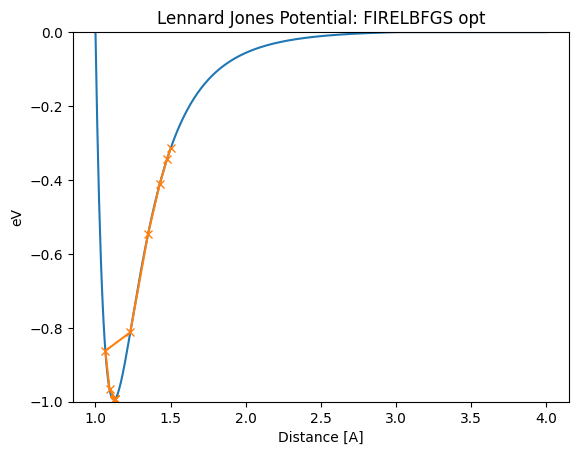

In [34]:
lennard_jones_trajectory(FIRELBFGS, 1.5)

           Step     Time          Energy         fmax
FIRELBFGS:    0 06:38:20       -0.697220        2.3246
FIRELBFGS:    1 06:38:20       -0.807702        2.3874
FIRELBFGS:    2 06:38:20       -0.987241        0.8220
FIRELBFGS:    3 06:38:20       -0.520102       13.5704
FIRELBFGS:    4 06:38:20       -0.971689        1.9036
FIRELBFGS:    5 06:38:20       -0.939109        1.8400
FIRELBFGS:    6 06:38:20       -0.943288        1.7937
FIRELBFGS:    7 06:38:20       -0.951214        1.6946
FIRELBFGS:    8 06:38:20       -0.961964        1.5294
FIRELBFGS:    9 06:38:20       -0.974030        1.2780
FIRELBFGS:   10 06:38:20       -0.985244        0.9149
FIRELBFGS:   11 06:38:20       -0.992867        0.4142
FIRELBFGS:   12 06:38:20       -0.994043        0.2396
FIRELBFGS:   13 06:38:20       -0.994061        0.2350
FIRELBFGS:   14 06:38:20       -0.994095        0.2259
FIRELBFGS:   15 06:38:20       -0.994143        0.2125
FIRELBFGS:   16 06:38:20       -0.994201        0.1951
FIRELBFGS: 

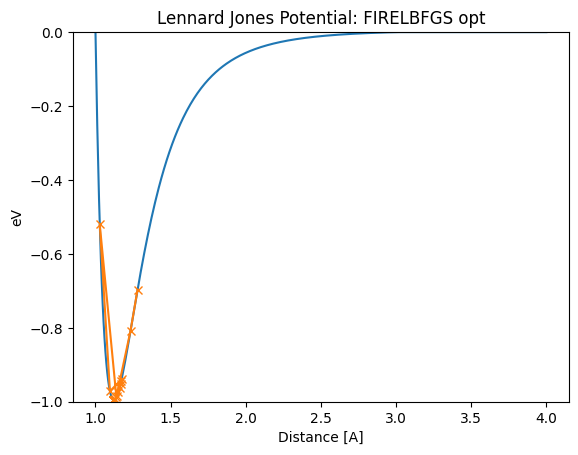

In [35]:
lennard_jones_trajectory(FIRELBFGS, 1.28)

## Further reading

The following books provide detailed explanations of the Newton method family, quasi-Newton methods, LineSearch, and other methods.

 - "Numerical Optimization" Jorge Nocedal, Stephan Wright https://doi.org/10.1007/978-0-387-40065-5

The original paper is the best source to understand FIRE.

 - [Structural Relaxation Made Simple](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.97.170201)


You may also study algorithms by reading ASE implementations.

In [36]:
from ase.optimize import FIRE
??FIRE

Init signature:
FIRE(
    atoms,
    restart=None,
    logfile='-',
    trajectory=None,
    dt=0.1,
    maxstep=None,
    maxmove=None,
    dtmax=1.0,
    Nmin=5,
    finc=1.1,
    fdec=0.5,
    astart=0.1,
    fa=0.99,
    a=0.1,
    master=None,
    downhill_check=False,
    position_reset_callback=None,
    force_consistent=None,
)
Docstring:      Base-class for all structure optimization classes.
Source:        
class FIRE(Optimizer):
    def __init__(self, atoms, restart=None, logfile='-', trajectory=None,
                 dt=0.1, maxstep=None, maxmove=None, dtmax=1.0, Nmin=5,
                 finc=1.1, fdec=0.5,
                 astart=0.1, fa=0.99, a=0.1, master=None, downhill_check=False,
                 position_reset_callback=None, force_consistent=None):
        """Parameters:

        atoms: Atoms object
            The Atoms object to relax.

        restart: string
            Pickle file used to store hessian matrix. If set, file with
            such a name will be se